In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train_df_subset = train_df.copy()

In [5]:
# Some pre processing 
train_df_subset = train_df_subset.drop(['Name'], axis = 1)

In [6]:
# Now Let's clean the Passenger Id. as you might recall the columns is made by 
# gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group
# Let's now create two columns for this and for now retain both. 

split_passenger_id = train_df_subset['PassengerId'].str.split('_', expand=True)
train_df_subset.loc[:,'Group'] = split_passenger_id[0]
train_df_subset.loc[:,'Number'] = split_passenger_id[1]

# Drop the passenger_id

train_df_subset.drop(columns=['PassengerId'], inplace = True)

print(train_df_subset)

     HomePlanet CryoSleep     Cabin    Destination   Age    VIP  RoomService  \
0        Europa     False     B/0/P    TRAPPIST-1e  39.0  False          0.0   
1         Earth     False     F/0/S    TRAPPIST-1e  24.0  False        109.0   
2        Europa     False     A/0/S    TRAPPIST-1e  58.0   True         43.0   
3        Europa     False     A/0/S    TRAPPIST-1e  33.0  False          0.0   
4         Earth     False     F/1/S    TRAPPIST-1e  16.0  False        303.0   
...         ...       ...       ...            ...   ...    ...          ...   
8688     Europa     False    A/98/P    55 Cancri e  41.0   True          0.0   
8689      Earth      True  G/1499/S  PSO J318.5-22  18.0  False          0.0   
8690      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False          0.0   
8691     Europa     False   E/608/S    55 Cancri e  32.0  False          0.0   
8692     Europa     False   E/608/S    TRAPPIST-1e  44.0  False        126.0   

      FoodCourt  ShoppingMall     Spa  

In [7]:
# Let's now do the same with cabin,.
#I want to do the same for the cabin columns in whih i want to have three divisions as
#cabin is deck/num/side i want to create three new columns with CabinDeck CAbinNum CabinSide let's go

split_cabin = train_df_subset['Cabin'].str.split('/', expand=True)

train_df_subset.loc[:,'Cabin Deck'] = split_cabin[0]
train_df_subset.loc[:,'Cabin Number'] = split_cabin[1]
train_df_subset.loc[:,'Cabin Side'] = split_cabin[2]


train_df_subset.drop(columns=['Cabin'], inplace= True)

print(train_df_subset)

     HomePlanet CryoSleep    Destination   Age    VIP  RoomService  FoodCourt  \
0        Europa     False    TRAPPIST-1e  39.0  False          0.0        0.0   
1         Earth     False    TRAPPIST-1e  24.0  False        109.0        9.0   
2        Europa     False    TRAPPIST-1e  58.0   True         43.0     3576.0   
3        Europa     False    TRAPPIST-1e  33.0  False          0.0     1283.0   
4         Earth     False    TRAPPIST-1e  16.0  False        303.0       70.0   
...         ...       ...            ...   ...    ...          ...        ...   
8688     Europa     False    55 Cancri e  41.0   True          0.0     6819.0   
8689      Earth      True  PSO J318.5-22  18.0  False          0.0        0.0   
8690      Earth     False    TRAPPIST-1e  26.0  False          0.0        0.0   
8691     Europa     False    55 Cancri e  32.0  False          0.0     1049.0   
8692     Europa     False    TRAPPIST-1e  44.0  False        126.0     4688.0   

      ShoppingMall     Spa 

In [8]:

# Select the columns you want to one-hot encode
columns_to_encode = ['HomePlanet', 'Destination', 'Cabin Deck', 'Cabin Side']

# Remove leading and trailing whitespace
train_df_subset[columns_to_encode] = train_df_subset[columns_to_encode].apply(lambda x: x.str.strip()) 

# Perform one-hot encoding on the selected columns
train_df_subset_hot = pd.get_dummies(train_df_subset[columns_to_encode])


# Concatenate the original X_test DataFrame with the one-hot encoded DataFrame
train_df_subset_hot = pd.concat([train_df_subset.drop(columns=columns_to_encode), train_df_subset_hot], axis = 1)

print(train_df_subset_hot)

     CryoSleep   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  \
0        False  39.0  False          0.0        0.0           0.0     0.0   
1        False  24.0  False        109.0        9.0          25.0   549.0   
2        False  58.0   True         43.0     3576.0           0.0  6715.0   
3        False  33.0  False          0.0     1283.0         371.0  3329.0   
4        False  16.0  False        303.0       70.0         151.0   565.0   
...        ...   ...    ...          ...        ...           ...     ...   
8688     False  41.0   True          0.0     6819.0           0.0  1643.0   
8689      True  18.0  False          0.0        0.0           0.0     0.0   
8690     False  26.0  False          0.0        0.0        1872.0     1.0   
8691     False  32.0  False          0.0     1049.0           0.0   353.0   
8692     False  44.0  False        126.0     4688.0           0.0     0.0   

      VRDeck  Transported Group  ... Cabin Deck_A Cabin Deck_B  Cabin Deck_

In [9]:
train_df_subset_hot.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Group', 'Number', 'Cabin Number',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Cabin Deck_A', 'Cabin Deck_B',
       'Cabin Deck_C', 'Cabin Deck_D', 'Cabin Deck_E', 'Cabin Deck_F',
       'Cabin Deck_G', 'Cabin Deck_T', 'Cabin Side_P', 'Cabin Side_S'],
      dtype='object')

In [10]:
train_df_subset_hot.dtypes

CryoSleep                     object
Age                          float64
VIP                           object
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Transported                     bool
Group                         object
Number                        object
Cabin Number                  object
HomePlanet_Earth                bool
HomePlanet_Europa               bool
HomePlanet_Mars                 bool
Destination_55 Cancri e         bool
Destination_PSO J318.5-22       bool
Destination_TRAPPIST-1e         bool
Cabin Deck_A                    bool
Cabin Deck_B                    bool
Cabin Deck_C                    bool
Cabin Deck_D                    bool
Cabin Deck_E                    bool
Cabin Deck_F                    bool
Cabin Deck_G                    bool
Cabin Deck_T                    bool
Cabin Side_P                    bool
C

In [11]:
train_df_subset_hot = train_df_subset_hot.dropna()

In [12]:
train_df_subset_hot['Group']

0       0001
1       0002
2       0003
3       0003
4       0004
        ... 
8688    9276
8689    9278
8690    9279
8691    9280
8692    9280
Name: Group, Length: 7084, dtype: object

In [13]:
train_df_subset_hot.dtypes

CryoSleep                     object
Age                          float64
VIP                           object
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Transported                     bool
Group                         object
Number                        object
Cabin Number                  object
HomePlanet_Earth                bool
HomePlanet_Europa               bool
HomePlanet_Mars                 bool
Destination_55 Cancri e         bool
Destination_PSO J318.5-22       bool
Destination_TRAPPIST-1e         bool
Cabin Deck_A                    bool
Cabin Deck_B                    bool
Cabin Deck_C                    bool
Cabin Deck_D                    bool
Cabin Deck_E                    bool
Cabin Deck_F                    bool
Cabin Deck_G                    bool
Cabin Deck_T                    bool
Cabin Side_P                    bool
C

In [14]:
# Given that XGBoost supports only boolean and numbers let's convert the object types to these types and
# see what happens 

numeric_col = ['Group', 'Number', 'Cabin Number']
bool_col = ['CryoSleep', 'VIP']

for col in numeric_col:
    train_df_subset_hot[col] = pd.to_numeric(train_df_subset_hot[col])

for col in bool_col:
    train_df_subset_hot[col] = train_df_subset_hot[col].map({'True': True, 'False': False}).astype(bool)

In [15]:
 train_df_subset_hot.dtypes

CryoSleep                       bool
Age                          float64
VIP                             bool
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Transported                     bool
Group                          int64
Number                         int64
Cabin Number                   int64
HomePlanet_Earth                bool
HomePlanet_Europa               bool
HomePlanet_Mars                 bool
Destination_55 Cancri e         bool
Destination_PSO J318.5-22       bool
Destination_TRAPPIST-1e         bool
Cabin Deck_A                    bool
Cabin Deck_B                    bool
Cabin Deck_C                    bool
Cabin Deck_D                    bool
Cabin Deck_E                    bool
Cabin Deck_F                    bool
Cabin Deck_G                    bool
Cabin Deck_T                    bool
Cabin Side_P                    bool
C

In [16]:
X = train_df_subset_hot.drop(['Transported'], axis = 1)
y = train_df_subset_hot['Transported']

In [17]:
print("X shape:", X.shape)
print("y shape", y.shape)

X shape: (7084, 27)
y shape (7084,)


In [18]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [19]:
print('X_train.shape:', X_train.shape)
print('X_test.shape:', X_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (5667, 27)
X_test.shape: (1417, 27)
y_train.shape: (5667,)
y_test.shape: (1417,)


In [20]:
from sklearn.ensemble import GradientBoostingClassifier 

clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 5,
                                  random_state = 42).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7953422724064926

In [21]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 5,
                                  random_state = 42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')

Accuracy: 0.7953422724064926


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(enable_categorical=True)
}

accuracies = []

for model_name, model in models.items():
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    accuracies.append(accuracy)
    
    print(f'{model_name} - Accuracy: {accuracy}')
    
    print(accuracies)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.7889908256880734
[0.7889908256880734]
Decision Tree - Accuracy: 0.7282992237120678
[0.7889908256880734, 0.7282992237120678]
Random Forest - Accuracy: 0.8016937191249118
[0.7889908256880734, 0.7282992237120678, 0.8016937191249118]
SVM - Accuracy: 0.7819336626676077
[0.7889908256880734, 0.7282992237120678, 0.8016937191249118, 0.7819336626676077]
KNN - Accuracy: 0.7748764996471419
[0.7889908256880734, 0.7282992237120678, 0.8016937191249118, 0.7819336626676077, 0.7748764996471419]
XGBoost - Accuracy: 0.808045165843331
[0.7889908256880734, 0.7282992237120678, 0.8016937191249118, 0.7819336626676077, 0.7748764996471419, 0.808045165843331]


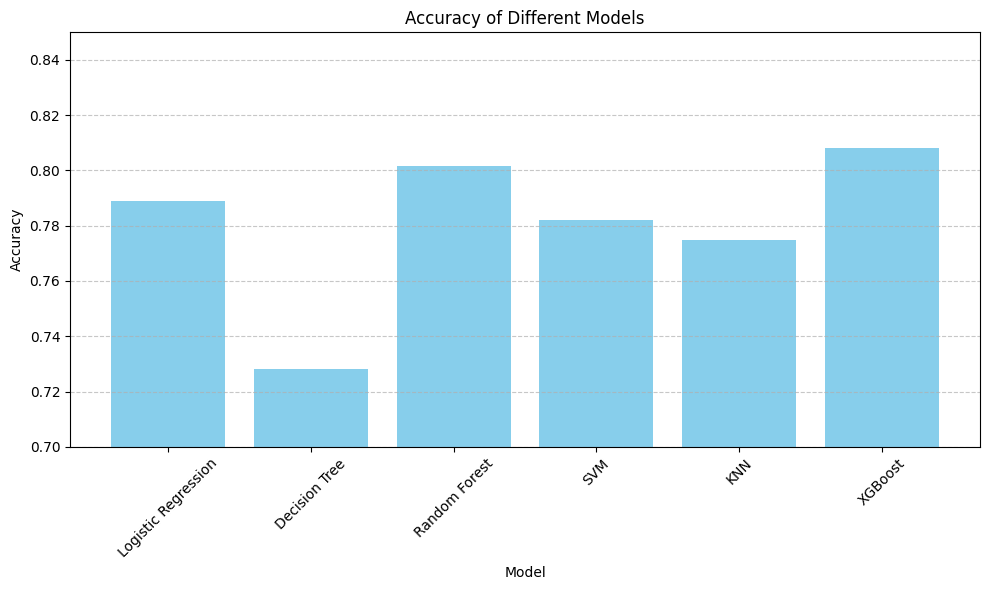

In [23]:
import matplotlib.pyplot as plt

# Extract model names and accuracies
model_names = list(models.keys())
accuracies 
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
plt.ylim(0.7, 0.85)  # Set ylim for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
# Let's apply the same pre-processing to the test_set

test_df_subset = test_df.copy()

# Some pre-processing 
test_df_subset = test_df_subset.drop(['Name'], axis=1)

# Split the PassengerId into Group and Number columns
split_passenger_id = test_df_subset['PassengerId'].str.split('_', expand=True)
test_df_subset['Group'] = split_passenger_id[0]
test_df_subset['Number'] = split_passenger_id[1]

# Drop the PassengerId column
test_df_subset.drop(columns=['PassengerId'], inplace=True)

# Split the Cabin into Cabin Deck, Cabin Number, and Cabin Side columns
split_cabin = test_df_subset['Cabin'].str.split('/', expand=True)
test_df_subset['Cabin Deck'] = split_cabin[0]
test_df_subset['Cabin Number'] = split_cabin[1]
test_df_subset['Cabin Side'] = split_cabin[2]

# Drop the Cabin column
test_df_subset.drop(columns=['Cabin'], inplace=True)

# Select the columns you want to one-hot encode
columns_to_encode = ['HomePlanet', 'Destination', 'Cabin Deck', 'Cabin Side']

# Remove leading and trailing whitespace
test_df_subset[columns_to_encode] = test_df_subset[columns_to_encode].apply(lambda x: x.str.strip())

# Perform one-hot encoding on the selected columns
test_df_subset_hot = pd.get_dummies(test_df_subset[columns_to_encode])

# Concatenate the original test_df DataFrame with the one-hot encoded DataFrame
test_df_subset_hot = pd.concat([test_df_subset.drop(columns=columns_to_encode), test_df_subset_hot], axis=1)

# Drop rows with missing values
#test_df_subset_hot = test_df_subset_hot.dropna()

# Convert object types to numeric and boolean
numeric_col = ['Group', 'Number', 'Cabin Number']
bool_col = ['CryoSleep', 'VIP']

for col in numeric_col:
    test_df_subset_hot[col] = pd.to_numeric(test_df_subset_hot[col].astype(str).str.zfill(4), errors='coerce')

for col in bool_col:
    test_df_subset_hot[col] = test_df_subset_hot[col].map({'True': True, 'False': False}).astype(bool)


In [25]:
test_df_subset_hot.shape

(4277, 27)

In [26]:
test_df_subset_hot.dtypes 

CryoSleep                       bool
Age                          float64
VIP                             bool
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Group                          int64
Number                         int64
Cabin Number                 float64
HomePlanet_Earth                bool
HomePlanet_Europa               bool
HomePlanet_Mars                 bool
Destination_55 Cancri e         bool
Destination_PSO J318.5-22       bool
Destination_TRAPPIST-1e         bool
Cabin Deck_A                    bool
Cabin Deck_B                    bool
Cabin Deck_C                    bool
Cabin Deck_D                    bool
Cabin Deck_E                    bool
Cabin Deck_F                    bool
Cabin Deck_G                    bool
Cabin Deck_T                    bool
Cabin Side_P                    bool
Cabin Side_S                    bool
d

In [27]:
print('test_df_subset_hot:', test_df_subset_hot.shape)
print('train_df_subset_hot:', train_df_subset_hot.shape)


test_df_subset_hot: (4277, 27)
train_df_subset_hot: (7084, 28)


In [28]:
test_df_subset_hot.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Group', 'Number', 'Cabin Number', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Cabin Deck_A',
       'Cabin Deck_B', 'Cabin Deck_C', 'Cabin Deck_D', 'Cabin Deck_E',
       'Cabin Deck_F', 'Cabin Deck_G', 'Cabin Deck_T', 'Cabin Side_P',
       'Cabin Side_S'],
      dtype='object')

In [29]:
model1 = xgb.XGBClassifier(enable_categorical = True)

model.fit(X_train, y_train)

y_pred_test = model.predict(test_df_subset_hot)


In [30]:
test_df_subset_hot.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,Number,...,Cabin Deck_A,Cabin Deck_B,Cabin Deck_C,Cabin Deck_D,Cabin Deck_E,Cabin Deck_F,Cabin Deck_G,Cabin Deck_T,Cabin Side_P,Cabin Side_S
0,True,27.0,True,0.0,0.0,0.0,0.0,0.0,13,1,...,False,False,False,False,False,False,True,False,False,True
1,True,19.0,True,0.0,9.0,0.0,2823.0,0.0,18,1,...,False,False,False,False,False,True,False,False,False,True
2,True,31.0,True,0.0,0.0,0.0,0.0,0.0,19,1,...,False,False,True,False,False,False,False,False,False,True
3,True,38.0,True,0.0,6652.0,0.0,181.0,585.0,21,1,...,False,False,True,False,False,False,False,False,False,True
4,True,20.0,True,10.0,0.0,635.0,0.0,0.0,23,1,...,False,False,False,False,False,True,False,False,False,True


In [31]:
test_df_subset_hot

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,Number,...,Cabin Deck_A,Cabin Deck_B,Cabin Deck_C,Cabin Deck_D,Cabin Deck_E,Cabin Deck_F,Cabin Deck_G,Cabin Deck_T,Cabin Side_P,Cabin Side_S
0,True,27.0,True,0.0,0.0,0.0,0.0,0.0,13,1,...,False,False,False,False,False,False,True,False,False,True
1,True,19.0,True,0.0,9.0,0.0,2823.0,0.0,18,1,...,False,False,False,False,False,True,False,False,False,True
2,True,31.0,True,0.0,0.0,0.0,0.0,0.0,19,1,...,False,False,True,False,False,False,False,False,False,True
3,True,38.0,True,0.0,6652.0,0.0,181.0,585.0,21,1,...,False,False,True,False,False,False,False,False,False,True
4,True,20.0,True,10.0,0.0,635.0,0.0,0.0,23,1,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,True,34.0,True,0.0,0.0,0.0,0.0,0.0,9266,2,...,False,False,False,False,False,False,True,False,False,True
4273,True,42.0,True,0.0,847.0,17.0,10.0,144.0,9269,1,...,False,False,False,False,False,False,False,False,False,False
4274,True,NaN,True,0.0,0.0,0.0,0.0,0.0,9271,1,...,False,False,False,True,False,False,False,False,True,False
4275,True,NaN,True,0.0,2680.0,0.0,0.0,523.0,9273,1,...,False,False,False,True,False,False,False,False,True,False


In [32]:
# There is something strange here it seems that I have some duplicates as I have 4276 on the side suggesting that number of 
# rows but then I have only 3491 actual rows. Let's check for duplicates 

duplicated_index = test_df_subset_hot.duplicated().sum()
duplicated_index

0

In [33]:
# Ok no duplicates. Even worst. 
missing_values = test_df_subset_hot.index.isnull().sum()
print("Number of missing values in index:", missing_values)

Number of missing values in index: 0


In [34]:
# No nulls, clearly... even worse...

consecutive_index = all(test_df_subset_hot.index[i] == i for i in range(len(test_df_subset_hot)))
print("Index is consecutive:", consecutive_index)

Index is consecutive: True


In [35]:
# AHAAAA the index is not from zero! that's the issue let's reset it
test_df_subset_hot.reset_index(drop=True, inplace=True)

In [36]:
#Did it work? 
consecutive_index = all(test_df_subset_hot.index[i] == i for i in range(len(test_df_subset_hot)))
print("Index is consecutive:", consecutive_index)

Index is consecutive: True


In [37]:
test_df_subset_hot

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,Number,...,Cabin Deck_A,Cabin Deck_B,Cabin Deck_C,Cabin Deck_D,Cabin Deck_E,Cabin Deck_F,Cabin Deck_G,Cabin Deck_T,Cabin Side_P,Cabin Side_S
0,True,27.0,True,0.0,0.0,0.0,0.0,0.0,13,1,...,False,False,False,False,False,False,True,False,False,True
1,True,19.0,True,0.0,9.0,0.0,2823.0,0.0,18,1,...,False,False,False,False,False,True,False,False,False,True
2,True,31.0,True,0.0,0.0,0.0,0.0,0.0,19,1,...,False,False,True,False,False,False,False,False,False,True
3,True,38.0,True,0.0,6652.0,0.0,181.0,585.0,21,1,...,False,False,True,False,False,False,False,False,False,True
4,True,20.0,True,10.0,0.0,635.0,0.0,0.0,23,1,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,True,34.0,True,0.0,0.0,0.0,0.0,0.0,9266,2,...,False,False,False,False,False,False,True,False,False,True
4273,True,42.0,True,0.0,847.0,17.0,10.0,144.0,9269,1,...,False,False,False,False,False,False,False,False,False,False
4274,True,NaN,True,0.0,0.0,0.0,0.0,0.0,9271,1,...,False,False,False,True,False,False,False,False,True,False
4275,True,NaN,True,0.0,2680.0,0.0,0.0,523.0,9273,1,...,False,False,False,True,False,False,False,False,True,False


In [38]:
# Now the problem is that I don't have a PassengerID anymore!! I have to reinsert it. Easily enough 
# I can just concatenate the group + the number. However I am still missing some leading zeros. 
# So let's frist write a quick function to fill them. 

def leading_zero_G(x):
    return str(x).zfill(4)


def leading_zero_N(x):
    return str(x).zfill(2)

In [39]:
test_df_subset_hot['Group'] = test_df_subset_hot['Group'].apply(leading_zero_G)
test_df_subset_hot['Number'] = test_df_subset_hot['Number'].apply(leading_zero_N)

In [40]:
test_df_subset_hot['Number']

0       01
1       01
2       01
3       01
4       01
        ..
4272    02
4273    01
4274    01
4275    01
4276    01
Name: Number, Length: 4277, dtype: object

In [41]:
#Recombine group and number into PassengerID
test_df_subset_hot['PassengerID'] = test_df_subset_hot['Group'].astype(str) + '_' + test_df_subset_hot['Number'].astype(str)

In [42]:
test_df_subset_hot['PassengerID']

0       0013_01
1       0018_01
2       0019_01
3       0021_01
4       0023_01
         ...   
4272    9266_02
4273    9269_01
4274    9271_01
4275    9273_01
4276    9277_01
Name: PassengerID, Length: 4277, dtype: object

In [43]:
y_pred_test = np.where(y_pred_test == 1, 'True', 'False')
len(y_pred_test)

4277

In [44]:
results = pd.DataFrame({'PassengerId': test_df_subset_hot["PassengerID"], 'Transported': y_pred_test})
results.to_csv("submission.csv", header=True, index=None)

In [45]:
pd.read_csv('submission.csv')

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True
